In [3]:
import pandas as pd

# Load dataset
df = pd.read_csv("archive/vehicles.csv")

# View first 5 rows
print(df.head())

# Check shape and structure
print("\nShape:", df.shape)
print("\nColumn info:")
print(df.info())

# Check missing values
print("\nMissing values per column:")
print(df.isnull().sum().sort_values(ascending=False))


           id                                                url  \
0  7222695916  https://prescott.craigslist.org/cto/d/prescott...   
1  7218891961  https://fayar.craigslist.org/ctd/d/bentonville...   
2  7221797935  https://keys.craigslist.org/cto/d/summerland-k...   
3  7222270760  https://worcester.craigslist.org/cto/d/west-br...   
4  7210384030  https://greensboro.craigslist.org/cto/d/trinit...   

                   region                         region_url  price  year  \
0                prescott    https://prescott.craigslist.org   6000   NaN   
1            fayetteville       https://fayar.craigslist.org  11900   NaN   
2            florida keys        https://keys.craigslist.org  21000   NaN   
3  worcester / central MA   https://worcester.craigslist.org   1500   NaN   
4              greensboro  https://greensboro.craigslist.org   4900   NaN   

  manufacturer model condition cylinders  ... size  type paint_color  \
0          NaN   NaN       NaN       NaN  ...  NaN   NaN

In [4]:
# Drop columns not useful for ML
drop_cols = [
    'id', 'url', 'region_url', 'image_url', 'description',
    'county', 'lat', 'long', 'posting_date'
]

df.drop(columns=drop_cols, inplace=True)

# Preview cleaned dataframe
print("After dropping:", df.shape)
print(df.columns)


After dropping: (426880, 17)
Index(['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN',
       'drive', 'size', 'type', 'paint_color', 'state'],
      dtype='object')


In [5]:
# Keep only relevant columns
columns_to_keep = [
    'price', 'year', 'manufacturer', 'model', 'condition',
    'cylinders', 'fuel', 'odometer', 'title_status',
    'transmission', 'drive', 'type', 'paint_color',
    'state', 'region'
]

df = df[columns_to_keep]

# Preview again
print(df.head())
print("\nMissing values:\n", df.isnull().sum().sort_values(ascending=False))


   price  year manufacturer model condition cylinders fuel  odometer  \
0   6000   NaN          NaN   NaN       NaN       NaN  NaN       NaN   
1  11900   NaN          NaN   NaN       NaN       NaN  NaN       NaN   
2  21000   NaN          NaN   NaN       NaN       NaN  NaN       NaN   
3   1500   NaN          NaN   NaN       NaN       NaN  NaN       NaN   
4   4900   NaN          NaN   NaN       NaN       NaN  NaN       NaN   

  title_status transmission drive type paint_color state  \
0          NaN          NaN   NaN  NaN         NaN    az   
1          NaN          NaN   NaN  NaN         NaN    ar   
2          NaN          NaN   NaN  NaN         NaN    fl   
3          NaN          NaN   NaN  NaN         NaN    ma   
4          NaN          NaN   NaN  NaN         NaN    nc   

                   region  
0                prescott  
1            fayetteville  
2            florida keys  
3  worcester / central MA  
4              greensboro  

Missing values:
 cylinders       1776

In [ ]:
# Drop rows where 'price', 'year', or 'odometer' is missing or invalid
df = df[df['price'].notnull()]
df = df[df['year'].notnull()]
df = df[df['odometer'].notnull()]

# Drop rows with price <= 100 
df = df[df['price'] > 100]

# Convert year to integer 
df['year'] = df['year'].astype(int)

# Create new feature: car_age
df['car_age'] = 2025 - df['year']

# Drop year column since it's now represented in car_age
df.drop('year', axis=1, inplace=True)

# Preview cleaned dataset
print("Shape after cleaning:", df.shape)
print(df[['price', 'car_age', 'odometer']].head())

Shape after cleaning: (387099, 15)
    price  car_age  odometer
27  33590       11   57923.0
28  22590       15   71229.0
29  39590        5   19160.0
30  30990        8   41124.0
31  15000       12  128000.0


In [7]:
# Show remaining missing values
print(df.isnull().sum().sort_values(ascending=False))


cylinders       157338
condition       147600
drive           118241
paint_color     114561
type             83695
manufacturer     14614
title_status      7216
model             4525
fuel              2126
transmission      1519
price                0
odometer             0
state                0
region               0
car_age              0
dtype: int64


In [6]:
# Preview key categorical columns
for col in ['condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color']:
    print(f"\n{col}: {df[col].unique()}")



condition: ['good' 'excellent' 'fair' nan 'like new' 'new' 'salvage']

cylinders: ['8 cylinders' '6 cylinders' nan '4 cylinders' '5 cylinders' 'other'
 '3 cylinders' '10 cylinders' '12 cylinders']

fuel: ['gas' 'other' 'diesel' 'hybrid' nan 'electric']

title_status: ['clean' 'rebuilt' 'lien' nan 'salvage' 'missing' 'parts only']

transmission: ['other' 'automatic' 'manual' nan]

drive: [nan 'rwd' '4wd' 'fwd']

type: ['pickup' 'truck' 'other' nan 'coupe' 'SUV' 'hatchback' 'mini-van' 'sedan'
 'offroad' 'bus' 'convertible' 'wagon' 'van']

paint_color: ['white' 'blue' 'red' 'black' 'silver' 'grey' nan 'brown' 'yellow'
 'orange' 'green' 'custom' 'purple']


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Fill missing with 'unknown'
for col in ['fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'manufacturer']:
    df[col] = df[col].fillna('unknown')

# Clean cylinders
df['cylinders'] = df['cylinders'].str.extract('(\d+)').astype('float')
df['cylinders'] = df['cylinders'].fillna(df['cylinders'].median())  # Impute with median

# Encode 'condition' ordinally
condition_order = ['salvage', 'fair', 'good', 'excellent', 'like new', 'new']
df['condition'] = pd.Categorical(df['condition'], categories=condition_order, ordered=True)
df['condition'] = df['condition'].cat.codes.replace(-1, 0)  # Replace NaN with 0 ('salvage')

# Drop model for now 
df.drop(columns=['model'], inplace=True)

# One-hot encode remaining categorical features
df_encoded = pd.get_dummies(df, drop_first=True)

# Preview
print("Encoded DataFrame shape:", df_encoded.shape)
print(df_encoded.head())


<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Paris Buroko\AppData\Local\Temp\ipykernel_1836\3012167228.py:8: SyntaxWarning: invalid escape sequence '\d'
  df['cylinders'] = df['cylinders'].str.extract('(\d+)').astype('float')


Encoded DataFrame shape: (387099, 542)
    price  condition  cylinders  odometer  car_age  manufacturer_alfa-romeo  \
27  33590          2        8.0   57923.0       11                    False   
28  22590          2        8.0   71229.0       15                    False   
29  39590          2        8.0   19160.0        5                    False   
30  30990          2        8.0   41124.0        8                    False   
31  15000          3        6.0  128000.0       12                    False   

    manufacturer_aston-martin  manufacturer_audi  manufacturer_bmw  \
27                      False              False             False   
28                      False              False             False   
29                      False              False             False   
30                      False              False             False   
31                      False              False             False   

    manufacturer_buick  ...  region_winchester  region_winston-sa

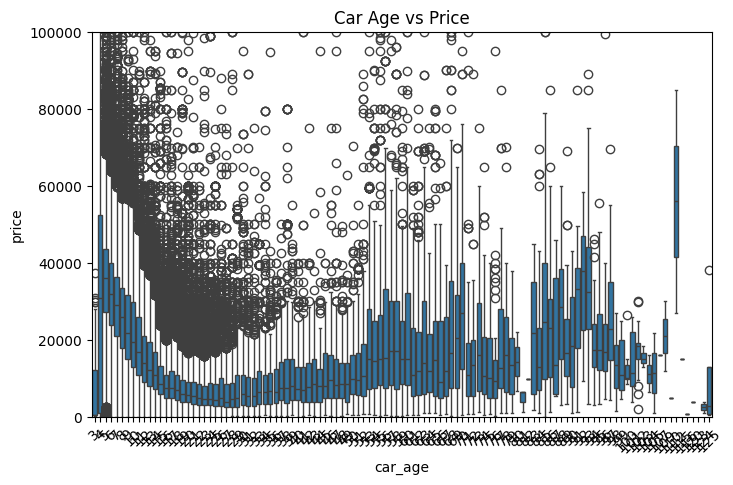

In [9]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='car_age', y='price', data=df)
plt.title("Car Age vs Price")
plt.ylim(0, 100000)
plt.xticks(rotation=45)
plt.show()


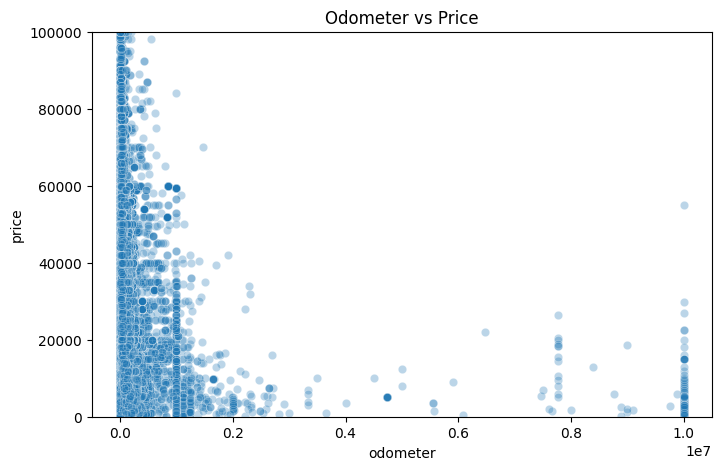

In [11]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='odometer', y='price', data=df, alpha=0.3)
plt.title("Odometer vs Price")
plt.ylim(0, 100000)
plt.show()


In [9]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (309679, 541)
Test shape: (77420, 541)


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)


In [14]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)


In [15]:
def evaluate_model(y_true, y_pred, name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"\n{name} Performance:")
    print("R² Score:", round(r2, 3))
    print("RMSE:", round(rmse, 2))

evaluate_model(y_test, lr_preds, "Linear Regression")
evaluate_model(y_test, rf_preds, "Random Forest")



Linear Regression Performance:
R² Score: -0.005
RMSE: 6031954.83

Random Forest Performance:
R² Score: -2.764
RMSE: 11672104.54


Max price: 3736928711


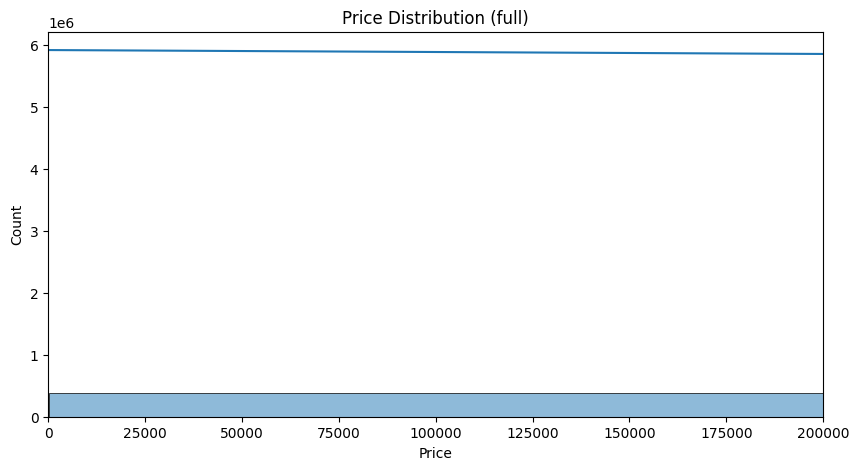

In [16]:
# Check max price
print("Max price:", df['price'].max())

# Plot distribution again (zoomed in)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df['price'], bins=100, kde=True)
plt.title("Price Distribution (full)")
plt.xlabel("Price")
plt.xlim(0, 200000)  # limit to focus on majority
plt.show()


In [17]:
print("Cars over $100K:", df[df['price'] > 100000].shape[0])

Cars over $100K: 647


In [ ]:
# Remove unrealistic prices
df = df[(df['price'] >= 1000) & (df['price'] <= 100000)]

# Re-encode
df_encoded = pd.get_dummies(df, drop_first=True)

# Train-test split
from sklearn.model_selection import train_test_split
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Retrain Random Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# Evaluate
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def evaluate_model(y_true, y_pred, name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"\n{name} Performance:")
    print("R² Score:", round(r2, 3))
    print("RMSE:", round(rmse, 2))

evaluate_model(y_test, rf_preds, "Random Forest (Cleaned)")



Random Forest (Cleaned) Performance:
R² Score: 0.894
RMSE: 4661.49


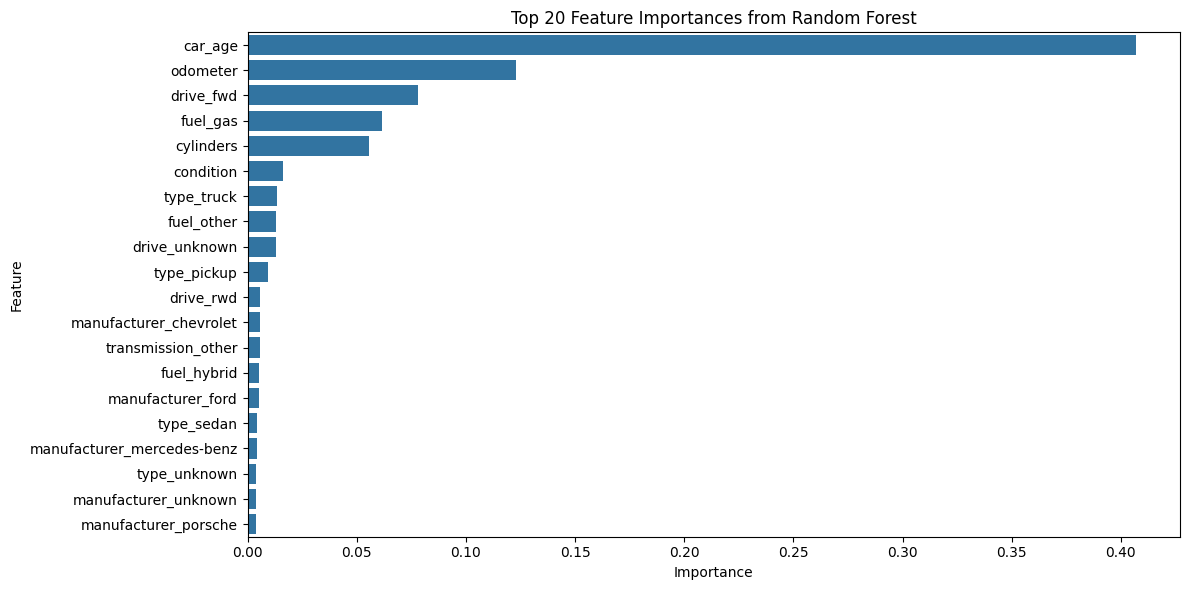

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Get feature importances from trained Random Forest
importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp.head(20))
plt.title('Top 20 Feature Importances from Random Forest')
plt.tight_layout()
plt.show()
